In [1]:
# Import the libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

pd.set_option('display.max_columns', None)

2024-04-07 16:23:04.855817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
raw_df = pd.read_csv('data/spotify_tracks_dataset.csv')
raw_df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


### Preprocessing

In [107]:
df = raw_df.copy()
print('Shape of dataframe:', df.shape)

# Remove null row
print('Step 1: Removing rows with NA')
df.dropna(inplace=True)

# Remove "Unnamed: 0" field, and remove any duplicate tracks
print("Step 2: Drop 'Unnamed: 0' column, and remove duplicate tracks")
df = df.drop(columns = ["Unnamed: 0"])
df = df.drop_duplicates()

# Keep tracks with only 1 labeled genre
print('Step 3: Drop tracks with more than one assigned genre')
num_tracks_ids = df['track_id'].value_counts()
single_tracks_ids = num_tracks_ids[num_tracks_ids==1].index.tolist()
df = df[df['track_id'].isin(single_tracks_ids)]

# With duplicate tracks and tracks with multiple genres removed, drop unnecessary columns for classification
print("Step 4: Drop columns not needed for classification: 'track_id', 'artists', 'album_name','track_name','time_signature'")
df = df.drop(columns = ["track_id", "artists", "album_name","track_name","time_signature"])

print('Shape of dataframe:', df.shape)

Shape of dataframe: (114000, 21)
Step 1: Removing rows with NA
Step 2: Drop 'Unnamed: 0' column, and remove duplicate tracks
Step 3: Drop tracks with more than one assigned genre
Step 4: Drop columns not needed for classification: 'track_id', 'artists', 'album_name','track_name','time_signature'
Shape of dataframe: (73441, 15)


### Feature Engineering

In [108]:
# Map explicit field to binary
df['explicit'] = df['explicit'].apply(lambda x: 1 if x == True else 0)

# One hot encode key field
df = pd.get_dummies(df, columns=['key'], dtype=int)
df = df.rename(columns={"key_0":"C","key_1":"C#","key_2":"D","key_3":"D#","key_4":"E","key_5":"F",
                        "key_6":"F#","key_7":"G","key_8":"G#","key_9":"A","key_10":"A#","key_11":"B"})

df['popularity'] = df['popularity'].astype(int)
df['duration_ms'] = df['duration_ms'].astype(int)
df['mode'] = df['mode'].astype(int)

print(df.shape)
df.head()

# Conversion from ms to minutes
# max(df['duration_ms'])/1000/60

(73441, 26)


,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
2,57,210826,0,0.438,0.3590,-9.734,1,0.0557,0.210,0.000000,0.1170,0.120,76.332,acoustic,1,0,0,0,0,0,0,0,0,0,0,0
3,71,201933,0,0.266,0.0596,-18.515,1,0.0363,0.905,0.000071,0.1320,0.143,181.740,acoustic,1,0,0,0,0,0,0,0,0,0,0,0
4,82,198853,0,0.618,0.4430,-9.681,1,0.0526,0.469,0.000000,0.0829,0.167,119.949,acoustic,0,0,1,0,0,0,0,0,0,0,0,0
8,74,189613,0,0.625,0.4140,-8.700,1,0.0369,0.294,0.000000,0.1510,0.669,130.088,acoustic,1,0,0,0,0,0,0,0,0,0,0,0
10,74,244800,0,0.627,0.3630,-8.127,1,0.0291,0.279,0.000000,0.0928,0.301,99.905,acoustic,0,0,0,0,0,0,0,0,1,0,0,0


In [109]:
# Bin the popularity field
df['popularity_bin'] = pd.qcut(df.popularity,q=5,labels=[1,2,3,4,5])
df = pd.get_dummies(df, columns=['popularity_bin'], dtype=int)

# Remove tracks that are less than 60 seconds
df = df[df['duration_ms'] > 60000]

# Keep tracks with duration within 98th percentile
df[df['duration_ms'] < df['duration_ms'].quantile(.98)]

# Bin the duration_ms field
df['duration_bin'] = pd.qcut(df.duration_ms,q=5,labels=[1,2,3,4,5])
df = pd.get_dummies(df, columns=['duration_bin'], dtype=int)
df

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,popularity_bin_1,popularity_bin_2,popularity_bin_3,popularity_bin_4,popularity_bin_5,duration_bin_1,duration_bin_2,duration_bin_3,duration_bin_4,duration_bin_5
2,57,210826,0,0.438,0.3590,-9.734,1,0.0557,0.210,0.000000,0.1170,0.1200,76.332,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,71,201933,0,0.266,0.0596,-18.515,1,0.0363,0.905,0.000071,0.1320,0.1430,181.740,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,82,198853,0,0.618,0.4430,-9.681,1,0.0526,0.469,0.000000,0.0829,0.1670,119.949,acoustic,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
8,74,189613,0,0.625,0.4140,-8.700,1,0.0369,0.294,0.000000,0.1510,0.6690,130.088,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
10,74,244800,0,0.627,0.3630,-8.127,1,0.0291,0.279,0.000000,0.0928,0.3010,99.905,acoustic,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0,0.172,0.2350,-16.393,1,0.0422,0.640,0.928000,0.0863,0.0339,125.995,world-music,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
113996,22,385000,0,0.174,0.1170,-18.318,0,0.0401,0.994,0.976000,0.1050,0.0350,85.239,world-music,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
113997,22,271466,0,0.629,0.3290,-10.895,0,0.0420,0.867,0.000000,0.0839,0.7430,132.378,world-music,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
113998,41,283893,0,0.587,0.5060,-10.889,1,0.0297,0.381,0.000000,0.2700,0.4130,135.960,world-music,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [110]:
##GIVE CREDIT TO KAGGLE HERE
genre_to_category = {
    # EDM
    'edm': 'Electronic Dance Music', 
    'techno': 'Electronic Dance Music', 
    # 'house': 'Electronic Dance Music', 
    # 'electro': 'Electronic Dance Music', 
    # 'trance': 'Electronic Dance Music', 
    # 'dubstep': 'Electronic Dance Music', 
    'drum-and-bass': 'Electronic Dance Music', 
    # 'deep-house': 'Electronic Dance Music', 
    # 'detroit-techno': 'Electronic Dance Music', 
    # 'minimal-techno': 'Electronic Dance Music', 
    'progressive-house': 'Electronic Dance Music', 
    # 'breakbeat': 'Electronic Dance Music',
    
    # Rock
    'alt-rock': 'Rock', 
    'rock': 'Rock', 
    # 'indie': 'Rock', 
    'punk': 'Rock', 
    # 'punk-rock': 'Rock', 
    'hard-rock': 'Rock', 
    'metal': 'Rock', 
    'heavy-metal': 'Rock', 
    # 'black-metal': 'Rock', 
    # 'death-metal': 'Rock', 
    # 'grunge': 'Rock',
    # 'metalcore': 'Rock',
    # 'psych-rock': 'Rock',
    # 'rock-n-roll': 'Rock',
    
    # Hip-Hop and R&B
    'hip-hop': 'Hip-Hop and R&B', 
    'r-n-b': 'Hip-Hop and R&B', 
    'funk': 'Hip-Hop and R&B',
    'trap': 'Hip-Hop and R&B',

    # Country
    'country': 'Country',
    'bluegrass': 'Country',
    'honky-tonk': 'Country',

    # Classical
    'classical': 'Classical', 
    'opera': 'Classical', 
    
    # Pop
    'pop': 'Pop', 
    'k-pop': 'Pop', 
    # 'j-pop': 'Pop', 
    # 'electro-pop': 'Pop', 
    # 'synth-pop': 'Pop', 
    'pop-film': 'Pop', 
    # 'power-pop': 'Pop',
    # 'indie-pop': 'Pop', 
    # 'cantopop': 'Pop', 
    
    # Latin & Reggaeton
    'latin': 'Latin & Reggaeton', 
    'latino': 'Latin & Reggaeton', 
    'reggaeton': 'Latin & Reggaeton', 
    'salsa': 'Latin & Reggaeton',
    'samba': 'Latin & Reggaeton', 
    # 'reggae': 'Latin & Reggae/Dancehall', 
    # 'dancehall': 'Latin & Reggae/Dancehall',
    
    # Disco
    # 'disco': 'Disco', 
    # 'groove': 'Disco',
}

# Map each track to a category
df['music_category'] = df['track_genre'].apply(lambda x: genre_to_category.get(x, 'Other'))

slim_df = df[df['music_category'] != 'Other']
slim_df.shape

(13770, 37)

In [111]:
# Set features to use in model
features = [
    # 'popularity',
    # 'duration_ms',
    'explicit',
    'danceability',
    'energy',
    'loudness',
    # 'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    # 'C',
    # 'C#',
    # 'D',
    # 'D#',
    # 'E',
    # 'F',
    # 'F#',
    # 'G',
    # 'G#',
    # 'A',
    # 'A#',
    # 'B',
    'popularity_bin_1',
    'popularity_bin_2',
    'popularity_bin_3',
    'popularity_bin_4',
    'popularity_bin_5',
    'duration_bin_1',
    'duration_bin_2',
    'duration_bin_3',
    'duration_bin_4',
    'duration_bin_5'
]

# Load tracks and genre labels
tracks = slim_df[features]
labels = slim_df['music_category']
labels_count = len(labels.unique())

print("Shape of tracks ", tracks.shape)
print("Shape of labels ", labels.shape)

Shape of tracks  (13770, 20)
Shape of labels  (13770,)


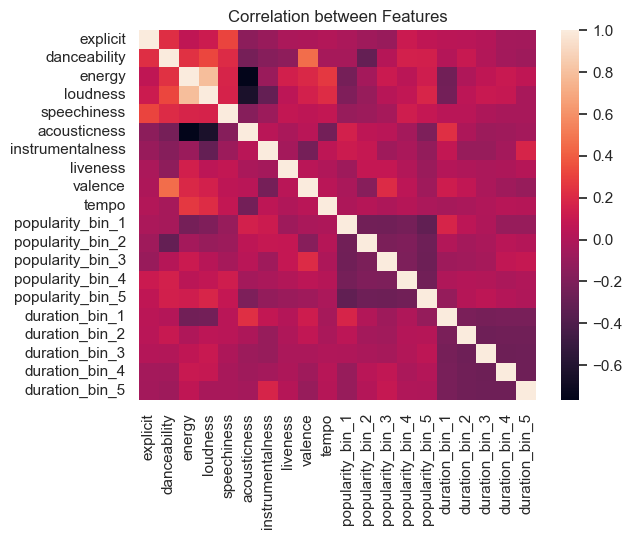

In [112]:
ax = sns.heatmap(tracks.corr()).set(title = "Correlation between Features")

<Axes: >

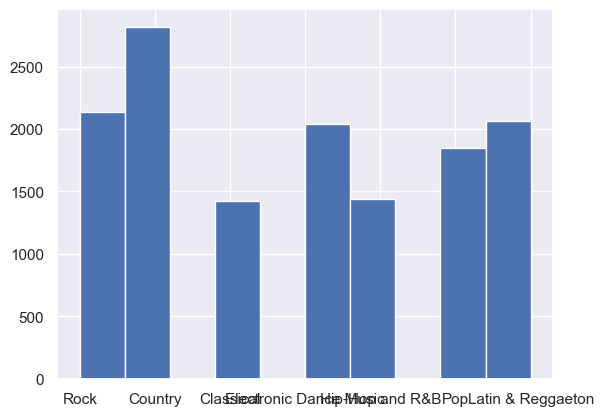

In [113]:
slim_df['music_category'].hist()

In [114]:
slim_df['music_category'].value_counts()

music_category
Country                   2818
Rock                      2134
Latin & Reggaeton         2065
Electronic Dance Music    2040
Pop                       1847
Hip-Hop and R&B           1440
Classical                 1426
Name: count, dtype: int64

### Shuffle Data

In [115]:
# Apply random shufflying to training examples.
np.random.seed(4)
indices = np.arange(tracks.shape[0])
shuffled_indices = np.random.permutation(indices)
tracks = tracks.iloc[shuffled_indices]
labels = labels.iloc[shuffled_indices]

### Create uniform distribution of classes

In [116]:
min_count = labels.value_counts().min()
result = {}
unique_classes = np.unique(labels)
for value in unique_classes:
    indices = np.where(labels==value)[0][:min_count]
    result[value] = indices.tolist()
index_values = list(result.values())
index_values = [element for nestedlist in index_values for element in nestedlist]
tracks = tracks.iloc[index_values]
labels = labels.iloc[index_values]

<Axes: >

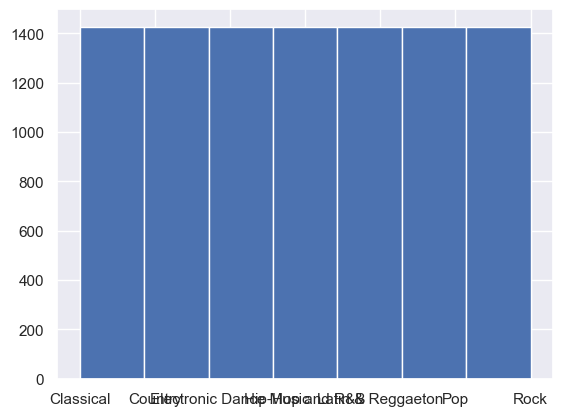

In [117]:
labels.hist(bins=labels_count)

### Encode labels, and normalize data

In [118]:
# Encode the target variable
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Normalize the feature set
scaler = StandardScaler()
tracks_scaled = scaler.fit_transform(tracks)

### Train/Test split

In [119]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(tracks_scaled, labels_encoded, test_size = 0.2, random_state=42)

# Print shapes of train and test data 
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', Y_train.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', Y_test.shape)

print('Check for any null values:', np.isnan(X_train).sum() + np.isnan(Y_train).sum() + np.isnan(X_test).sum() + np.isnan(Y_test).sum())

Shape of train images  (7985, 20)
Shape of train labels  (7985,)
Shape of test images  (1997, 20)
Shape of test labels  (1997,)
Check for any null values: 0


### Build Model

In [120]:
def build_model(num_features, n_classes,learning_rate=0.01):
    """Build a TF logistic regression model using Keras.
    
    Args:
    learning_rate: The desired learning rate for SGD.
    
    Returns:
    model: A tf.keras model (graph).
    """
    # Random Seed + Clear Session
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Build a model using keras.Sequential.
    model = keras.Sequential(name = 'Genres')
    
    # Keras layers processing
    model.add(tf.keras.layers.InputLayer(input_shape=num_features))

    #adding extra layer
    model.add(keras.layers.Dense(
            units=256,
            activation = 'relu'))
    
    # This layer constructs the linear set of parameters for each input feature
    # (as well as a bias), and applies a sigmoid to the result. The result is
    # binary logistic regression.
    model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'))

    # Use the SGD optimizer as usual.
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # We specify the binary_crossentropy loss (equivalent to log loss).
    # Notice that we are including 'binary accuracy' as one of the metrics that we
    # ask Tensorflow to report when evaluating the model.
    model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])
    
    return model

In [121]:
model = build_model(num_features = X_train.shape[1], n_classes = labels_count)
model.summary()

Model: "Genres"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 7,175
Trainable params: 7,175
Non-trainable params: 0
_________________________________________________________________


In [122]:
# Fit the model.
history = model.fit(
  x = X_train,   # training examples
  y = Y_train,   #labels
  epochs=10,             # number of passes through the training data
  batch_size=128,        # mini-batch size for SGD
  validation_split=0.25, # use a fraction of the examples for validation -- DO WE STILL NEED THIS IF VALIDATION SPLIT
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

Epoch 1/10
47/47 [==============================] - 0s 2ms/step - loss: 1.8617 - accuracy: 0.2786 - val_loss: 1.7427 - val_accuracy: 0.3480
Epoch 2/10
47/47 [==============================] - 0s 968us/step - loss: 1.6429 - accuracy: 0.4339 - val_loss: 1.5661 - val_accuracy: 0.4712
Epoch 3/10
47/47 [==============================] - 0s 999us/step - loss: 1.4918 - accuracy: 0.5234 - val_loss: 1.4377 - val_accuracy: 0.5328
Epoch 4/10
47/47 [==============================] - 0s 958us/step - loss: 1.3794 - accuracy: 0.5783 - val_loss: 1.3397 - val_accuracy: 0.5824
Epoch 5/10
47/47 [==============================] - 0s 970us/step - loss: 1.2922 - accuracy: 0.6174 - val_loss: 1.2631 - val_accuracy: 0.6159
Epoch 6/10
47/47 [==============================] - 0s 1ms/step - loss: 1.2230 - accuracy: 0.6356 - val_loss: 1.2021 - val_accuracy: 0.6335
Epoch 7/10
47/47 [==============================] - 0s 1ms/step - loss: 1.1675 - accuracy: 0.6440 - val_loss: 1.1529 - val_accuracy: 0.6425
Epoch 8/10
4

,loss,accuracy,val_loss,val_accuracy
0,1.861658,0.278557,1.742749,0.348022
1,1.642884,0.433868,1.566079,0.471207
2,1.491842,0.523380,1.437674,0.532799
3,1.379399,0.578323,1.339745,0.582374
4,1.292213,0.617401,1.263114,0.615924
5,1.223038,0.635605,1.202068,0.633450
6,1.167474,0.643955,1.152897,0.642464
7,1.122176,0.651470,1.112872,0.650976
8,1.084883,0.656981,1.079907,0.654482
9,1.053805,0.662325,1.052464,0.659990


In [123]:
test_accuracy = model.evaluate(x=X_test, y=Y_test, verbose=0,return_dict=True)['accuracy']
print('Test Accuracy:', test_accuracy)

Test Accuracy: 0.68052077293396


63/63 [==============================] - 0s 449us/step


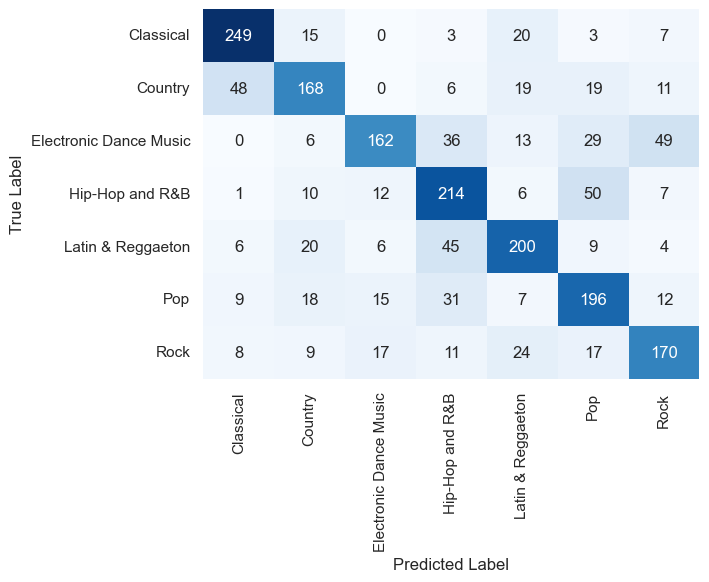

In [124]:
# Recall that model.predict gives a vector of probabilities for each x.
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions = np.argmax(model.predict(X_test), axis=-1)

# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=labels.unique(), yticklabels=labels.unique(), cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [125]:
# Calculating precision for each class
for i in range(labels_count):
    prec = tf.keras.backend.get_value(confusion_matrix[:,i][i]) / np.sum(tf.keras.backend.get_value(confusion_matrix[:,i]))
    print(round(prec,3),":",labels.unique()[i])

0.776 : Classical
0.683 : Country
0.764 : Electronic Dance Music
0.618 : Hip-Hop and R&B
0.692 : Latin & Reggaeton
0.607 : Pop
0.654 : Rock


<Axes: >

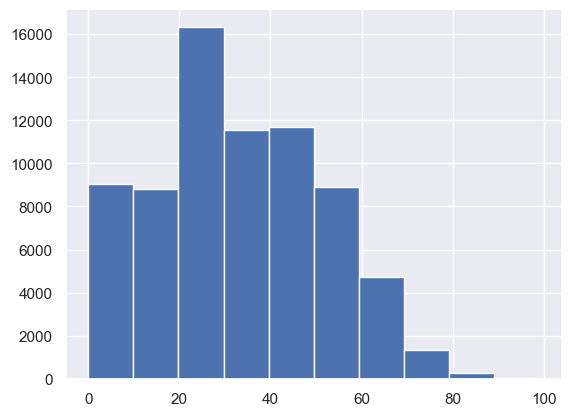

In [88]:
df['popularity'].hist()